In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import namedtuple
from scipy.special import logsumexp

### The Model

$$Y_t = \beta \exp(X_t/2)V_t$$
$$X_{t+1} = \phi X_t + \sigma W_t $$

$$V_t, W_t \sim N(0,1)$$

In [2]:
# simulate
def simulate(T, beta, phi, sigma, seed=0):
    np.random.seed(seed)
    x = np.zeros(T)
    x[0] = np.random.normal()

    for t in range(1, T):
        x[t] = np.random.normal(loc=phi * x[t - 1], scale=sigma)
    y = beta * np.exp(x / 2) * np.random.normal(size=T)

    return x, y

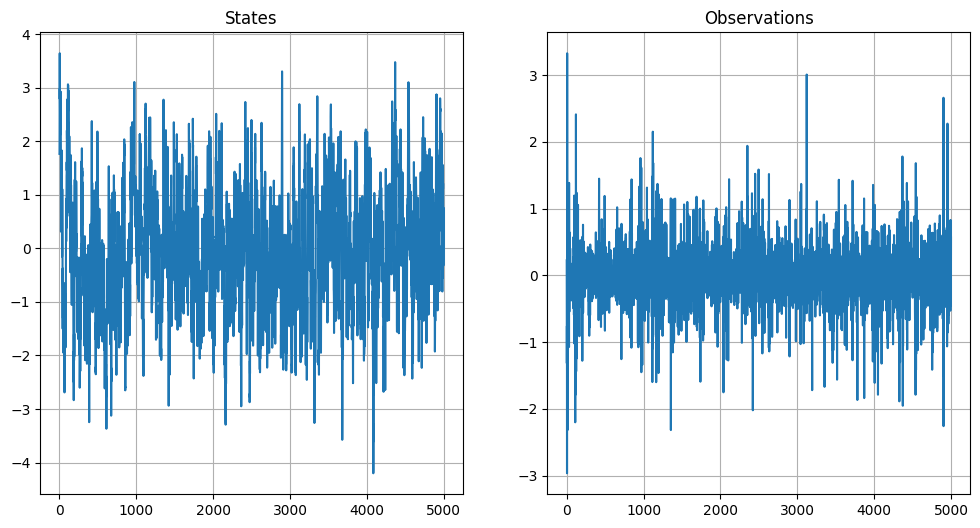

In [4]:
T= 5000 # time steps
beta = 0.3
phi = 0.9
sigma= 0.5
states, observations = simulate(T, beta, phi, sigma)
fig, ax = plt.subplots(figsize=(12, 6),ncols=2, nrows=1)
ax[0].plot(states)
ax[0].set_title('States')
ax[0].grid()
ax[1].plot(observations)
ax[1].set_title('Observations')
ax[1].grid()

In [36]:
def q(y, x, beta):
    return st.norm.pdf(y, loc=beta * np.exp(x / 2), scale=1)


def log_q(y, x, beta):
    return st.norm.logpdf(y, loc=beta * np.exp(x / 2), scale=1)


def p(x_2, x_1, phi, sigma):
    return st.norm.pdf(x_2, loc=phi * x_1, scale=sigma)


def resample_propogate_log(N, observation, particles, beta, phi, sigma):
    logw = log_q(observation, particles, beta)
    logw -= logsumexp(logw)
    w = np.exp(logw)
    s = np.sum(w)

    if s == 0 or not np.isfinite(s):
        w = np.ones(N) / N
    else:
        w /= s

    resamples = np.random.choice(a=particles, size=N, p=w)
    particles = np.random.normal(loc=phi * resamples, scale=sigma)
    return particles


def d_beta(beta, y, x):
    return q(y, x, beta) * (-1 / beta + y**2 / beta**3 / np.exp(x))


def d_phi(phi, sigma, x_2, x_1):
    return p(x_2, x_1, phi, sigma) * ((x_2 - phi * x_1) / sigma**2 * x_1)


def d_sigma(phi, sigma, x_2, x_1):
    return p(x_2, x_1, phi, sigma) * (-1 / sigma + (x_2 - phi * x_1) ** 2 / sigma**3)


def a(n):
    return 0.05 / (n + 1) ** 0.6


def estimate_params(
    T,
    observations,
    initial_beta=0.1,
    initial_phi=0.8,
    initial_sigma=0.5,
    N=1000,
    seed=0,
):
    # initial config
    np.random.seed(seed)
    beta, phi, sigma = initial_beta, initial_phi, initial_sigma
    d = 3  # number of parameters
    Params = namedtuple("Params", "beta phi sigma")
    params = Params(0, 1, 2)
    particles = np.random.normal(loc=0, size=N)

    weights = 1 / N * np.ones((d, N))

    evolution = [(beta, phi, sigma)]

    for j in range(T - 1):
        observation = observations[j]
        next_particles = resample_propogate_log(
            N, observation, particles, beta, phi, sigma
        )
        next_observation = observations[j + 1]
        new_weights = np.empty((d, N))
        for i in range(N):
            normaliser = np.sum(
                (
                    p(next_particles[i], particles, phi, sigma)
                    * q(observation, particles, beta)
                )
            )
            if normaliser == 0:
                continue
            new_weights[params.beta][i] = (
                np.sum(
                    p(next_particles[i], particles, phi, sigma)
                    * d_beta(beta, observation, particles)
                )
                + np.sum(
                    p(next_particles[i], particles, phi, sigma)
                    * q(observation, particles, beta)
                    * weights[params.beta]
                )
            ) / normaliser
            new_weights[params.phi][i] = (
                np.sum(
                    d_phi(phi, sigma, next_particles[i], particles)
                    * q(observation, particles, beta)
                )
                + np.sum(
                    p(next_particles[i], particles, phi, sigma)
                    * q(observation, particles, beta)
                    * weights[params.phi]
                )
            ) / normaliser
            new_weights[params.sigma][i] = (
                np.sum(
                    d_sigma(phi, sigma, next_particles[i], particles)
                    * q(observation, particles, beta)
                )
                + np.sum(
                    p(next_particles[i], particles, phi, sigma)
                    * q(observation, particles, beta)
                    * weights[params.sigma]
                )
            ) / normaliser
        new_weights = new_weights - np.reshape(np.mean(new_weights, axis=1), (d, 1))
        normaliser = np.sum(q(next_observation, next_particles, beta))
        if normaliser != 0:  # normaliser == 0 iff all probabilities are zero
            phi += (
                a(j)
                * np.sum(
                    q(next_observation, next_particles, beta) * new_weights[params.phi]
                )
                / normaliser
            )
            phi = min(max(phi, 0.1), 1.5)
            sigma += (
                a(j)
                * np.sum(
                    q(next_observation, next_particles, beta)
                    * new_weights[params.sigma]
                )
                / normaliser
            )
            sigma = min(max(sigma, 0.01), 2)
            beta += (
                a(j)
                * (
                    np.sum(
                        q(next_observation, next_particles, beta)
                        * new_weights[params.beta]
                    )
                    + np.sum(d_beta(beta, next_observation, next_particles))
                )
                / normaliser
            )
            beta = min(max(beta, 0.1), 2)

        weights = new_weights
        evolution.append((beta, phi, sigma))

        # print("params:",evolution)
        print(f"Iteration {j + 1}/{T - 1} beta:{beta}, phi:{phi}, sigma:{sigma})")

        particles = next_particles
    return evolution

In [37]:
def plot_param_estimation(guesses):
    guesses = np.array(guesses)
    guesses_t = guesses.T

    betas = guesses_t[0]
    phis = guesses_t[1]
    sigmas = guesses_t[2]

    fig, ax = plt.subplots()

    ax.plot(betas, label="beta", color="red")
    ax.hlines(
        y=beta,
        xmin=0,
        xmax=len(betas),
        label="true beta",
        linestyle="dashed",
        color="red",
    )

    ax.plot(phis, label="phi", color="green")
    ax.hlines(
        y=phi,
        xmin=0,
        xmax=len(phis),
        label="true phi",
        linestyle="dashed",
        color="green",
    )

    ax.plot(sigmas, label="sigma", color="blue")
    ax.hlines(
        y=sigma,
        xmin=0,
        xmax=len(phis),
        label="true sigma",
        linestyle="dashed",
        color="blue",
    )

    fig.legend()
    ax.grid()
    fig.set_figheight(6)
    fig.set_figwidth(10)

In [38]:
guesses = estimate_params(T=200, observations=observations, N=1000)

Iteration 1/199 beta:2, phi:0.7993921556478868, sigma:0.49956336869825113)
Iteration 2/199 beta:2, phi:0.8834172445525657, sigma:0.5355937626818391)
Iteration 3/199 beta:2, phi:0.9525462817160891, sigma:0.5636766178089881)
Iteration 4/199 beta:2, phi:1.087489462235665, sigma:0.634491555051299)
Iteration 5/199 beta:1.9815770650000557, phi:1.0738734958810798, sigma:0.6271675796717909)
Iteration 6/199 beta:1.6438374771349518, phi:0.9407811951112224, sigma:0.6003496151586694)
Iteration 7/199 beta:1.5852513536703203, phi:0.9317507584642508, sigma:0.5948990230806812)
Iteration 8/199 beta:1.9619725482017225, phi:0.974835609664793, sigma:0.5976997993366115)
Iteration 9/199 beta:2, phi:1.0075779876436761, sigma:0.601986516830319)
Iteration 10/199 beta:1.9585305415797871, phi:0.9972462832487419, sigma:0.5986033186014266)
Iteration 11/199 beta:2, phi:1.0532718342684637, sigma:0.6065116201447873)
Iteration 12/199 beta:2, phi:1.0667816104480987, sigma:0.6082188811834245)
Iteration 13/199 beta:2, ph

/tmp/ipykernel_98169/2603943683.py:30: RuntimeWarning: overflow encountered in divide
  return q(y, x, beta) * (-1 / beta + y**2 / beta**3 / np.exp(x))
/tmp/ipykernel_98169/2603943683.py:84: RuntimeWarning: invalid value encountered in multiply
  p(next_particles[i], particles, phi, sigma)


Iteration 37/199 beta:2, phi:1.195482934590953, sigma:0.6290647045567842)


/tmp/ipykernel_98169/2603943683.py:30: RuntimeWarning: divide by zero encountered in divide
  return q(y, x, beta) * (-1 / beta + y**2 / beta**3 / np.exp(x))


Iteration 38/199 beta:nan, phi:1.195482934590953, sigma:0.6290647045567842)
Iteration 39/199 beta:nan, phi:nan, sigma:nan)
Iteration 40/199 beta:nan, phi:nan, sigma:nan)
Iteration 41/199 beta:nan, phi:nan, sigma:nan)
Iteration 42/199 beta:nan, phi:nan, sigma:nan)
Iteration 43/199 beta:nan, phi:nan, sigma:nan)
Iteration 44/199 beta:nan, phi:nan, sigma:nan)
Iteration 45/199 beta:nan, phi:nan, sigma:nan)
Iteration 46/199 beta:nan, phi:nan, sigma:nan)
Iteration 47/199 beta:nan, phi:nan, sigma:nan)
Iteration 48/199 beta:nan, phi:nan, sigma:nan)
Iteration 49/199 beta:nan, phi:nan, sigma:nan)
Iteration 50/199 beta:nan, phi:nan, sigma:nan)
Iteration 51/199 beta:nan, phi:nan, sigma:nan)
Iteration 52/199 beta:nan, phi:nan, sigma:nan)
Iteration 53/199 beta:nan, phi:nan, sigma:nan)
Iteration 54/199 beta:nan, phi:nan, sigma:nan)
Iteration 55/199 beta:nan, phi:nan, sigma:nan)
Iteration 56/199 beta:nan, phi:nan, sigma:nan)
Iteration 57/199 beta:nan, phi:nan, sigma:nan)
Iteration 58/199 beta:nan, phi: